In [1]:
# Link from https://nthu-datalab.github.io/ml/labs/04-1_Perceptron_Adaline/04-1_Perceptron_Adaline.html
# inline plotting instead of popping out
%matplotlib inline

import os, math
from IPython.display import Image
import numpy as np
seed = np.random.seed

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Data Preparation
We use the *Iris* dataset from the UCI machine learning repository, which is one of the best known datasets in classification. It consists of 150 iris plants as examples, each with the sepal and petal sizes as attributes and the type as class label. Let's download the Iris dataset using *Pandas* first:

In [2]:
df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/'
    'machine-learning-databases/iris/iris.data',
    header = None
)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.head())

X = df[['Petal length', 'Petal width']].values
# similar to one hot encoding
y = pd.factorize(df['Class label'])[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

print('#Training data points: {}'.format(X_train.shape[0]))
print('#Testing data points: {}'.format(X_test.shape[0]))
print('Class labels: {} (mapped from {}'.format(np.unique(y), np.unique(df['Class label'])))

,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#Training data points: 100
#Testing data points: 50
Class labels: [0 1 2] (mapped from ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


# Standardization for Gradient Descent
Recall from the lecture that the gradient descent may perform poorly if the Hessian of the function  $f$  to be minimized has a large condition number. In this case, the surface of  $f$  can be curvy in some directions but flat in the others. Therefore, the gradient descent, which ignores the curvatures, may overshoot the optimal point along curvy directions but take too small step along flat ones.

One common way to improve the conditioning of  $f$  is to standardize dataset  $X$  , as follows:

In [5]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

Note: the standardization should calculate the mean  μ  and variance  σ2  using only the training set, as the testing set must be remain unknown during the entire training process.

# Training Perceptron via Scikit-learn
Having standardized the training data, we can now train a Perceptron model:

In [6]:
# max_iter : The maximum number of passes over the training data
# eta0 : learning rate
ppn = Perceptron(max_iter=10, eta0=0.1, random_state=0)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, max_iter=10)

In [7]:
y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Misclassified samples: 5
Accuracy: 0.90


In [10]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[: len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x = X[y == cl, 0],
            y = X[y == cl, 1],
            alpha = 0.8,
            c = [cmap(idx)], # Prevents warning
            marker = markers[idx],
            label = cl
        )

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set', edgecolors='k')

We get 90% accuracy. Now let's plot the decision boundaries to see how the model works:


<ipython-input-10-48f8011d57d5>:38: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


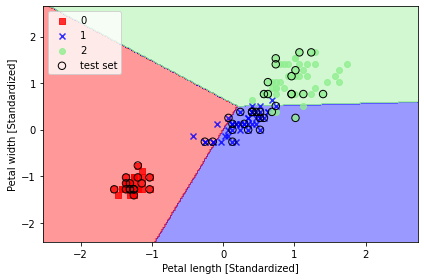

In [11]:
import os

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(len(y_train),
                                                      len(y_train) + len(y_test)))
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
if  not os.path.exists('./output'):
    os.mkdir('./output')
plt.savefig('./output/fig-perceptron-scikit.png', dpi=300)
plt.show()

# Multiclass Classification¶
The Perceptron model is originally designed for the binary classification problems. However, we can see from the above that the model implemented in the Scikit-learn is able to predict the labels of multiple classes (3 in this case). This is achieved by wrapping the binary model with an **One-vs-All (or One-vs-Rest)** procedure. If there are  K  classes, then this procedure trains  K  binary classifiers for each class, where each classifier treats only one class as positive and the rests as negative. To predict the label of a testing data point, each classifier generates the soft output  $f(x)=w^⊤x−b∈R$  for every class, and then the class who gets the highest output value becomes the predicted label.

# Implementing Perceptron
Now it's time to implement a classifier by our own. For simplicity, we only implement the binary Perceptron model. This can be easily done as follows:


In [12]:
class Perceptron2(object):
    """Perceptron classifier.
    
    Parameters
    ------------
    eta: float 
        Learning rate (between 0.0 and 1.0)
    n_iter: int
        Number of epochs, i.e., passes over the training dataset.
        
    Attributes
    ------------
    w_: 1d-array
        Weights after fitting.
    errors_: list
        Number of misclassifications in every epoch.
    random_state : int
        The seed of the pseudo random number generator.
    """
    
    def __init__(self, eta=0.01, n_iter=10, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values, or labels.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.errors_ = []
        
        for _ in range(self.n_iter):
            errors = 0.0
            for xi, yi in zip(X, y):
                output = self.predict(xi)
                error = (yi - output)
                self.w_[1:] += self.eta * error * xi
                self.w_[0] += self.eta * error
                errors += int(error != 0.0)
            self.errors_.append(errors)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

# NOTE:

1. we could have implemented the shorthand version of  $X$  and  $w$  to include the bias term. However, we single out the addition of the bias term (self.w_[0]) for performance reason, as adding a vector of 1's to the training array each time we want to make a prediction would be inefficient.
2. some production implementation shuffles data in the beginning of each epoch. We omit this step for simplicity.

To train our binary Perceptron model using the Iris dataset, we recreate our training and testing sets so that they contain only binary labels:



In [14]:
y[50:150]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [15]:
# discard exmaples in the first class
X = X[50:150]
# if y[50:150] == 2 -> yes, value = -1, else value = y[50:150] = 1
y = np.where(y[50:150] == 2, -1, y[50:150])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))


#Training data points: 90
#Testing data points: 10
Class labels: [-1  1]


Let train model

Misclassified samples: 3
Accuracy: 0.70


<ipython-input-10-48f8011d57d5>:38: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


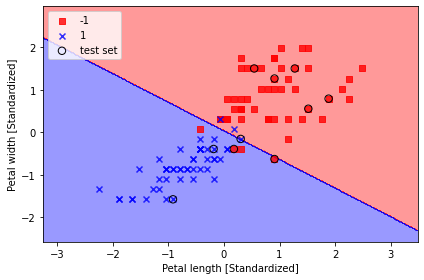

In [16]:
# training

ppn2 = Perceptron2(eta=0.1, n_iter=20)

ppn2.fit(X_train_std, y_train)

# testing

y_pred = ppn2.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# plot descision boundary

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined, 
                      classifier=ppn2, test_idx=range(len(y_train),
                                                      len(y_train) + len(y_test)))
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-perceptron2-boundary.png', dpi=300)
plt.show()

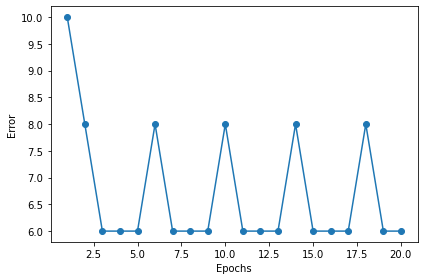

In [17]:
# track converge throght the errors attribute
plt.plot(range(1, len(ppn2.errors_) + 1), ppn2.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Error')

plt.tight_layout()
plt.savefig('./output/fig-perceptron2_errors.png', dpi=300)
plt.show()


As we can see, the weights never stop updating. To terminate the training process, we have to set a maximum number of epochs.


# Implementing Adaline with GD
The ADAptive LInear NEuron (Adaline) is similar to the Perceptron, except that it defines a cost function based on the soft output and an optimization problem. We can therefore leverage various optimization techniques to train Adaline in a more theoretic grounded manner. Let's implement the Adaline using the batch gradient descent (GD) algorithm:

In [19]:
class AdalineGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    random_state : int
        The seed of the pseudo random number generator.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values or labels.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.activation(X)
            
            # Cost function
            error = (y - output)
            cost = (error**2).sum() / 2.0
            self.cost_.append(cost)
            
            # Update rule
            self.w_[1:] += self.eta * X.T.dot(error)
            self.w_[0] += self.eta * error.sum()
            
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

As discussed in the lecture, a good learning rate  η  is a key to the optimal convergence. In practice, it often requires some experimentation to find a good learning rate. Let's plot the cost against the number of epochs for the two different learning rates:

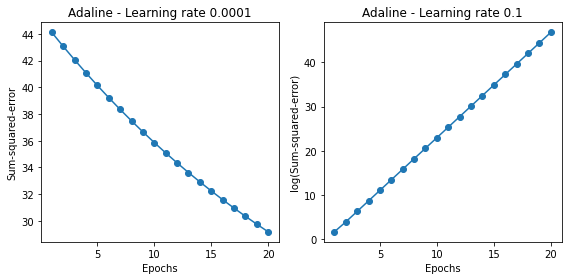

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# learning rate is small, converge slowly
ada1 = AdalineGD(n_iter=20, eta=0.0001).fit(X_train_std, y_train)
ax[0].plot(range(1, len(ada1.cost_) + 1), ada1.cost_, marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Sum-squared-error')
ax[0].set_title('Adaline - Learning rate 0.0001')

# Learning rate too big, does not converge and overshoot
ada2 = AdalineGD(n_iter=20, eta=0.1).fit(X_train_std, y_train)
ax[1].plot(range(1, len(ada2.cost_) + 1), np.log10(ada2.cost_), marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('log(Sum-squared-error)')
ax[1].set_title('Adaline - Learning rate 0.1')

plt.tight_layout()
plt.savefig('./output/fig-adaline-gd-overshoot.png', dpi=300)
plt.show()

With a properly chosen learning rate  η  , the AdalineGD converges and gives a better prediction accuracy (80%) as compared with the Perceptron (70%):

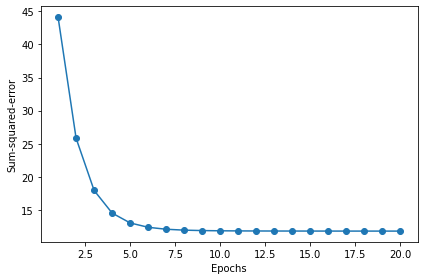

Misclassified samples: 2
Accuracy: 0.80


<ipython-input-10-48f8011d57d5>:38: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


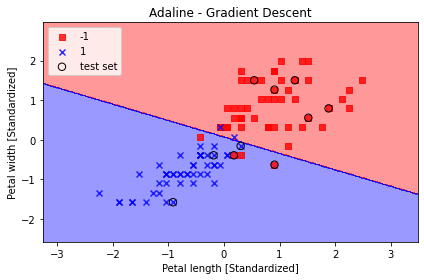

In [21]:
ada = AdalineGD(n_iter=20, eta=0.01)
ada.fit(X_train_std, y_train)

# cost values

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
plt.savefig('./output/fig-adalin-gd-cost.png', dpi=300)
plt.show()

# testing accuracy

y_pred = ada.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# plot decision boundary 

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=ada, test_idx=range(len(y_train),
                                                    len(y_train) + len(y_test)))
plt.title('Adaline - Gradient Descent')
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-adaline-gd-boundary.png', dpi=300)
plt.show()

# Implementing Adaline with SGD
Running the gradient descent can be computationally costly when the number of examples  N  in a training dataset is large since we need to scan the entire dataset every time to take one descent step. The stochastic gradient descent (SGD) update the weights incrementally for each minibatch of size  M ,  M≪N . SGD usually reaches convergence much faster because of the more frequent weight updates. Since each gradient is calculated based on few training examples, the point taken at each step may "wander" randomly and the cost value may not always decrease. However, this may be considered as an advantage in that it can escape shallow local minima when the cost function is not convex. To prevent SGD from wandering around the optimal point, we often replace the constant learning rate  η  by an adaptive learning rate that decreases over time. For example, we can let

$η=\frac{a}{t+b}$
 
where  $t$  is the iteration number and  $a$  and  $b$  are constants. Furthermore, to hold the assumption that each minibatch consists of "randomly sampled" points from the same data generation distribution when we regard the cost function as an expectation, it is important to feed SGD with data in a random order, which is why we shuffle the training set for every epoch.

Let's implement the Adaline with SGD. For simplicity, we use a constant learning rate and set  M=1 :

In [22]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state : seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values or labels.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, yi in zip(X, y):
                cost.append(self._update_weights(xi, yi))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, yi):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(xi)
        
        # Cost function
        error = (yi - output)
        cost = 0.5 * error**2
        
        # Update rule
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, yi in zip(X, y):
                self._update_weights(xi, yi)
        else:
            self._update_weights(X, y)
        return self

We pass `random_state` to np.random.seed so it will be used for shuffling and initializing the weights. If we modify the `activation()` method so that it is identical to the `predict()` method, then this class degenerates into the Perceptron with shuffling.

NOTE:

Although not shown in our implementation, setting a larger minibatch size  M>1  is advantages on modern CPU architecture as we can replace the for-loop over the training samples by vectorized operations, which is usually improve the computational efficiency. Vectorization means that an elemental arithmetic operation is automatically applied to all elements in an array. By formulating our arithmetic operations as a sequence of instructions on an array rather than performing a set of operations for each element one at a time, we can make better use of our modern CPU architectures with Single Instruction, Multiple Data (SIMD) support. Furthermore, many scientific libraries like NumPy use highly optimized linear algebra libraries, such as Basic Linear Algebra Subprograms (BLAS) and Linear Algebra Package (LAPACK) that implement vectorized operations in C or Fortran.

Let's see how Adaline performs with SGD:

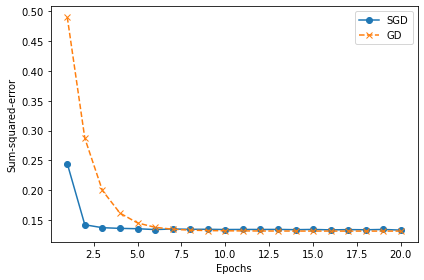

Misclassified samples: 2
Accuracy: 0.80


<ipython-input-10-48f8011d57d5>:38: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


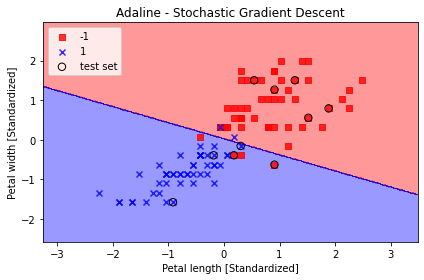

In [23]:
adas = AdalineSGD(n_iter=20, eta=0.01, random_state=1)
adas.fit(X_train_std, y_train)

# Cost values
plt.plot(range(1, len(adas.cost_) + 1), adas.cost_, 
         marker='o', label='SGD')
plt.plot(range(1, len(ada.cost_) + 1), np.array(ada.cost_) / len(y_train), 
         marker='x', linestyle='--', label='GD')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('./output/fig-adaline-sgd-cost.png', dpi=300)
plt.show()

# Testing accuracy
y_pred = adas.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# Plot decision boundary 
plot_decision_regions(X_combined_std, y_combined, 
                      classifier=adas, test_idx=range(len(y_train),
                                                      len(y_train) + len(y_test)))
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-adaline-sgd-boundary.png', dpi=300)
plt.show()

As we can see, the cost value goes down pretty quickly, and is only sightly worse than the (normalized) cost value of the batch gradient descent after 7 epochs.

Another advantage of stochastic gradient descent is that we can use it for **online learning**. In online learning, a model is trained on-the-fly as new training data arrives. This is especially useful if we are accumulating large amounts of data over time. For example, customer data in typical web applications. Using online learning, the system can immediately adapt to changes without training from the scratch. Furthermore, if storage space is an issue, we can discard the training data after updating the model. In our implementation, we provide the `partial_fit()` method for online learning.

